In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [62]:
file_path = 'C:/Users/Tim/Desktop/lighthouse/w6 - midterm/'
# filename = file_path+'flights.csv'

# n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
# s = 50000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s))
# df = pd.read_csv(filename,skiprows=skip)

filename = file_path+'mini_sample.csv'
df = pd.read_csv(filename)

In [111]:
data = copy.deepcopy(df)

In [112]:
# cols with > 80% missing values

drop = [
    'no_name',
    'total_add_gtime',
    'first_dep_time',
    'longest_add_gtime',
    'cancellation_code',
]

# missing 80%+ values, but apparently useful?

delay_cols = [
    'late_aircraft_delay',
    'security_delay',
    'nas_delay',
    'weather_delay',
    'carrier_delay'
]

In [113]:
# split city and country

data[['origin_city', 'origin_country']] = data['origin_city_name'].str.split(',', expand=True, n=2)

data[['dest_city', 'dest_country']] = data['dest_city_name'].str.split(',', expand=True, n=2)

# try using just city data, groupby country data?

In [114]:
# removing related carrier identifiers; commented out = used feature

carrier_identifiers = [
    'mkt_unique_carrier',
    'branded_code_share',
    #'mkt_carrier',
    'mkt_carrier_fl_num',
    'op_unique_carrier',
    'tail_num',
    'op_carrier_fl_num',
]

# removing related airport, place identifiers

place_identifiers = [
#origin identifiers
    'origin_airport_id',
    #'origin',
    'origin_city_name',
    'origin_city',
    'origin_country',
#destination identifiers
    'dest_airport_id',
    #'dest',
    'dest_city_name',
    'dest_city',
    'dest_country',
]

In [115]:
# avg flights per hr per airport -> fl traffic

data['hrly_bin'] = round(data['arr_time'],-2)
data['avg_hr_fl'] = data.groupby('dest')['hrly_bin'].transform(lambda x: len(x)/x.nunique())

In [116]:
# datetime

import datetime as dt
from datetime import date, time

In [117]:
# data['fl_date'] = pd.to_datetime(data['fl_date'])

# # month and year

# data['day_of_week'] = data['fl_date'].dt.date.isowekday()
# data['month'] = data['fl_date'].dt.month
# data['year'] = data['fl_date'].dt.year
data = data.sort_values(by=['fl_date'])

# dep_delay 7 day lag

data['dep_delay_lag'] = data['dep_delay'].shift(7)
data['arr_delay_lag'] = data['arr_delay'].shift(7)

# dep_delay 7 day mean

# data['ddl_rolling_mean'] = data['dep_delay'].rolling(window=30).mean()

data = data.drop(columns = 'fl_date')

In [118]:
data['adl_rolling_mean'] = data['arr_delay'].rolling(window=30).mean()

In [119]:
data = data.fillna(0)

In [120]:
# dep_time	          wheels_off	0.9725230213908642
# wheels_on	          arr_time	    0.9630471247128861
# crs_elapsed_time	  distance	    0.9827710593474663
# actual_elapsed_time air_time	    0.985116094313287

# flights = column of 1s

corr_drop = [
    'wheels_off',  #dep/arr time could have information on whether or not time of day affects delay
    'wheels_on',   #wheels off/on probably time spent in tarmac
    'timestamp',
    'dist_group',
]

# don't use dep_delay

extra_drop = [
    'flights',
    'origin_num_freight',
    'origin_num_passengers',
    'crs_elapsed_time',
    'crs_arr_daytime',
    'crs_dep_daytime',
    'actual_elapsed_time',
    'predicted_speed',
    'actual_speed',
    'dest_num_intl_dep',
    'origin_num_intl_arr',
    'dest_num_intl_arr',
    'mean_monthly_op_carrier_delay',
    'mean_mo_delay_origin_airport',
    'mean_mo_delay_dest_airport',
    'taxi_in',
    'taxi_out',
    'diverted',
    'cancelled',
    'dep_delay',
    'dep_time',
    'arr_time',
    'day_of_year'
]


data = data.drop(columns=corr_drop+extra_drop)

In [121]:
cd = data.groupby('mkt_unique_carrier').mean()['arr_delay']
cd = cd.reset_index()
cd.columns = ['mkt_unique_carrier','mean_carrier_arr_delay']
cd

,mkt_unique_carrier,mean_carrier_arr_delay
0,AA,12.695256
1,AS,14.490647
2,B6,13.136552
3,DL,13.219501
4,F9,11.224367
5,G4,14.273038
6,HA,16.506024
7,NK,11.337219
8,UA,12.960344
9,VX,14.318182


In [122]:
data = data.merge(cd, on=['mkt_unique_carrier'], how='left')

In [123]:
# op_carrier, origin, dest

data['mkt_carrier'] = pd.factorize(data['mkt_carrier'])[0]
data['origin'] = pd.factorize(data['origin'])[0]
data['dest'] = pd.factorize(data['dest'])[0]

In [124]:
# remove cols

data = data.drop(columns=
                #drop+       # already dropped
                #delay_cols+ # not really sure what to do with these columns (already dropped)
                carrier_identifiers+
                place_identifiers)

In [125]:
# features 

numerical = list(data.dtypes[data.dtypes != 'object'].index)

categorical = list(data.dtypes[data.dtypes == 'object'].index)

In [126]:
categorical

['weather_type']

In [127]:
numerical

['mkt_carrier',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'arr_delay',
 'air_time',
 'distance',
 'origin_fl_density',
 'dest_fl_density',
 'day',
 'month',
 'year',
 'weekday',
 'crs_arr_hour',
 'crs_dep_hour',
 'dest_num_passengers',
 'dest_num_freight',
 'origin_num_intl_dep',
 'season',
 'dep_early_morning',
 'origin_airport_size',
 'dest_airport_size',
 'mean_op_carrier_delay',
 'mean_delay_origin_airport',
 'mean_delay_dest_airport',
 'totalSnow_cm',
 'sunHour',
 'cloudcover',
 'precipMM',
 'hrly_bin',
 'avg_hr_fl',
 'dep_delay_lag',
 'arr_delay_lag',
 'ddl_rolling_mean',
 'adl_rolling_mean',
 'mean_carrier_arr_delay']

In [128]:
data = pd.get_dummies(data=data,columns=categorical,drop_first=True)

In [129]:
# crs_dep_time, arr_time are values in range 0-2.4k -> get hours only

data['crs_dep_hour'] = round(data['crs_dep_time']/60)
data['crs_arr_hour'] = round(data['crs_arr_time']/60)

data = data.drop(columns=['crs_dep_time','crs_arr_time'])

In [130]:
# reshuffle
data = data.sample(frac=1)
data = data.reset_index()
# data = data[data['arr_delay']<=200]

In [131]:
X = data.drop(columns = 'arr_delay')
#y = data['arr_delay']
y = data['adl_rolling_mean']

In [147]:
X.columns

Index(['index', 'mkt_carrier', 'origin', 'dest', 'air_time', 'distance',
       'origin_fl_density', 'dest_fl_density', 'day', 'month', 'year',
       'weekday', 'crs_arr_hour', 'crs_dep_hour', 'dest_num_passengers',
       'dest_num_freight', 'origin_num_intl_dep', 'season',
       'dep_early_morning', 'origin_airport_size', 'dest_airport_size',
       'mean_op_carrier_delay', 'mean_delay_origin_airport',
       'mean_delay_dest_airport', 'totalSnow_cm', 'sunHour', 'cloudcover',
       'precipMM', 'hrly_bin', 'avg_hr_fl', 'dep_delay_lag', 'arr_delay_lag',
       'ddl_rolling_mean', 'adl_rolling_mean', 'mean_carrier_arr_delay',
       'weather_type_Rainy', 'weather_type_Snowy', 'weather_type_Sunny'],
      dtype='object')

In [132]:
# scale/normalize

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaling

scaler = StandardScaler()
scaler.fit(X)

X_scale = scaler.transform(X)

<AxesSubplot:xlabel='adl_rolling_mean', ylabel='Count'>

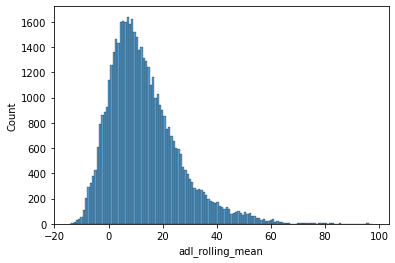

In [133]:
sns.histplot(y)

In [134]:
# splitting

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_scale,y,train_size=0.7)

In [135]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [146]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

model = XGBRegressor(objective ='reg:squarederror',
                     booster='gbtree',
                     learning_rate = 0.003,
                     colsample_bytree = 0.3,
                     max_depth = 10, 
                     alpha = 10,
                     n_estimators = 1000)
model.fit(x_train,y_train)

train_score = cross_val_score(model,x_train,y_train,cv=10)
print(round(train_score.mean(),2)*100)

99.0


In [138]:
y_pred = model.predict(x_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
print(metrics.r2_score(y_test,y_pred))

RMSE: 0.907723
0.9952621024928795


In [139]:
from sklearn.feature_selection import SelectFromModel

# select features using threshold
selection = SelectFromModel(model, prefit=True)
select_X_train = selection.transform(x_train)
# train model
selection_model = XGBRegressor(objective ='reg:squarederror',
                    booster='gbtree',
                    learning_rate = 0.03,
                    max_depth = 10, 
                    alpha = 10,
                    n_estimators = 100)
selection_model.fit(select_X_train, y_train)

select_X_test = selection.transform(x_test)
y_pred = selection_model.predict(select_X_test)
print(metrics.r2_score(y_test,y_pred))

0.9952621024928795


In [141]:
from sklearn.metrics import mean_squared_error

testing_error = mean_squared_error(y_test,y_pred)
print(testing_error)

exp_var = metrics.explained_variance_score(y_test,y_pred)
print(exp_var)

0.8239613221697718
0.9974304471219004


In [142]:
# optimization

from sklearn.model_selection import cross_validate

cv_results = cross_validate(selection_model,X,y,cv=10,scoring='r2',n_jobs=-1)

print(cv_results['test_score'])

[0.99543473 0.99530264 0.99540618 0.99548355 0.9954967  0.99502286
 0.99540771 0.9954576  0.99539402 0.99532531]
